# Clean Implementation
- Import all the functions from its libraries
- Leeave document as a nice report to follow

In [1]:
import os
import pickle
from pprint import pprint
from os.path import join as JP

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

from utils.nlp_utils import preproces
from utils.general import parse_yaml, ensure_directories

from scripts.catalog import (
    Catalog, Document, Corpus,
    load_catalog, load_corpus)

config = parse_yaml('config.yaml')
paths = config['paths']
ensure_directories(paths)

In [2]:
catalog = Catalog()

## Load Catalog

In [3]:
catalog = load_catalog(path=paths['catalog'], name='spacy_pipeline_on_US_corpus')
# catalog.documents[0].sp_doc

In [4]:
print(len(catalog.documents))

15


## TFIDF

### Collect the Corpus for Sklearn

In [5]:
corpus = catalog.collect_corpus(attr='processed_text', form=list)
document = corpus[0]
document[:500]

'application publish asahi glas method produce carbamate compound carbamate compound method produce isocyanate compound present invention relate method produce carbamate compound comprise react fluorine contain carbonic diester compound represent formula aromatic diamine compound represent formula catalyst produce carbamate compound represent formula method produce isocyanate compound represent formula carbamate compound catalyst represent fluorine contain represent divalent divalent divalent aro'

In [6]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from scripts.algorithms.clustering import (
    kmean_clustering,
    compute_word_importance,
    plot_clusters_as_wordclouds)

In [7]:
# TODO: Increase all these
EMBED_SIZE = 10000        
NUM_CLUSTERS = 4
WORDS_PER_CLUSTER = 50

In [8]:
vectorizer = TfidfVectorizer(
    min_df=.1,
    max_df=.7,
    norm='l2',
    use_idf=True,
    smooth_idf=True,
    max_features=EMBED_SIZE,
    ngram_range=(1,3),
    lowercase=True,
    stop_words=stopwords.words('english'))

In [9]:
tfidf = catalog.to_matrix(
    vectorizer=vectorizer,
    modelname='TFIDF',
    max_docs=None)
print(tfidf.representation.shape)
tfidf.representation.head()

(15, 9936)


,0000,0000 process,0000 process produce,0011,0015,0018,0021,0023,0028,0031,...,yield loss,yield low,yield method,yield mol,yield reaction,zeolite,zeolite diatomaceous,zeolite diatomaceous earth,zinc,zirconium
0,0.000000,0.000000,0.000000,0.0,0.005967,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.005967,0.004827,0.000000,0.000000,0.000000,0.004420,0.000000
1,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.003749,0.003749,0.000000,0.003749,...,0.000000,0.000000,0.0,0.000000,0.000000,0.003033,0.000000,0.000000,0.000000,0.000000
2,0.001422,0.000474,0.000474,0.0,0.000000,0.000474,0.000474,0.000474,0.000474,0.000000,...,0.000474,0.000474,0.0,0.000000,0.000767,0.000384,0.000474,0.000474,0.000351,0.000474
3,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.007083,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Clustering

In [10]:
cluster_words = kmean_clustering(
    model=tfidf,
    num_clusters=NUM_CLUSTERS,
    words_per_cluster=WORDS_PER_CLUSTER)

In [11]:
cluster_words

defaultdict(list,
            {0: ['aniline',
              'second',
              'tube',
              'stream',
              'column',
              'apparatus',
              'contact',
              'aqueous',
              'strip',
              'waste',
              'precursor compound',
              'vapor',
              'precursor',
              'process claim',
              'vaporization',
              'evaporator',
              'liquid phase',
              'distillation',
              'kg',
              'stage',
              'method invention',
              'formamide',
              'feed',
              'say',
              'unit',
              'bar',
              'tray',
              'deg',
              'plate',
              'thiol',
              'film evaporator',
              'synthesis',
              'gas',
              'film',
              'phenol',
              'upper',
              'clean',
              'bed',
              'section',
    

## Visualization

[INFO]: Computing word importance for each cluster
          words       idf  max_tf_idf  avg_tf_idf  norm_tf_idf
0          unit  1.826679    0.252627    0.252627     0.254093
1  distillation  1.470004    0.290041    0.290041     0.466898
2     apparatus  1.575364    0.676713    0.676713     0.714510
3           gas  1.374693    0.168695    0.168695     0.203244
4     synthesis  1.470004    0.106089    0.106089     0.172575
(49, 5)
[INFO]: Computing word importance for each cluster
       words       idf  max_tf_idf  avg_tf_idf  norm_tf_idf
0  formation  1.470004    0.085470    0.085470     0.146775
1       area  1.470004    0.102969    0.102969     0.126678
2     length  1.470004    0.091586    0.091586     0.108674
3      inlet  1.980829    0.107866    0.107866     0.137995
4     second  1.374693    0.325448    0.325448     0.562286
(49, 5)
[INFO]: Computing word importance for each cluster
       words       idf  max_tf_idf  avg_tf_idf  norm_tf_idf
0  carbamate  1.826679    0.52626

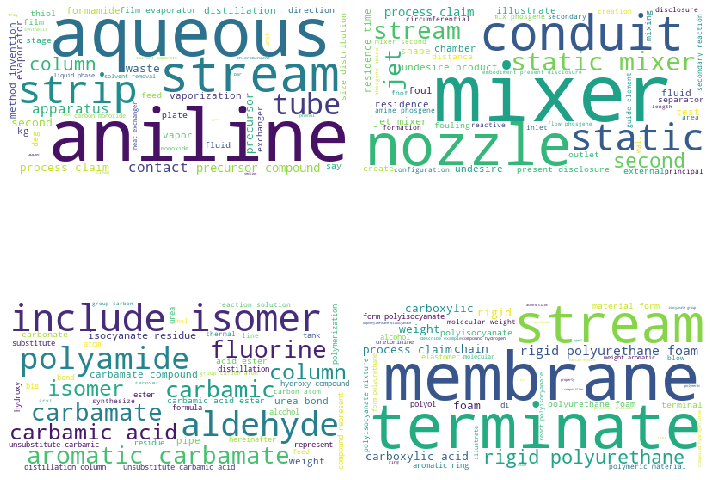

In [12]:
plot_clusters_as_wordclouds(tfidf, cluster_words, method='idf')